# Exploring Finite Differencing with FTBS Advection Equations in a Jupyter Notebook using *numpy* and *matplotlib*



This exercise models the advection of a simple wave using the forward-in-time/backward-in-space (FTBS) finite-differencing scheme

The user can set the certain constants and let the code do it's thing.

## Python Libraries

We start by loading the following libraries.  These are pretty frequently-used libraries:

* [numpy](https://docs.scipy.org/doc/numpy/): Numerical Python: Package for Scientific Computing
* [matplotlib](https://matplotlib.org): Basic Plotting Library leveraging MATLAB

You will also need a few extra things for animation:

* [IPython.display](https://ipython.org/ipython-doc/3/api/generated/IPython.display.html#module-IPython.display) : We will be pulling some HTML and gif generating functions


In [1]:
#############################################
#
# Load Python Libraries Because I am use to 
# doing them up-front
#

import matplotlib.pyplot    as plt
import numpy                as np

#
# needed for animation (in development)
#

import matplotlib.animation as animation
import IPython.display as display

#
#############################################

## User Modification Area

The user can modify a number parameters

| variable | description |
-----------|--------------
|nx | total grid cells |
|total_simtime | total simulation duration in seconds |
|U  | west-to-east wind speed in m s$^{-1}$ | 
|dx | horizontal space step in meters|
|dt | time step in seconds
|ndx | number of $\Delta x$ per wave  |
|hardwired_CFL | set to a value > 0 to set the time step to accomodate the requested CFL ($\frac{U \Delta t}{\Delta x}$) value|
|waves_per_system | number of waves running through the system |



In [2]:
#############################################
#
# User Modification Area
#

#
# set true for indivisual plots
#

make_individual_plots = False

#
# manual simulation settings
#

total_simtime = 3*3600. # units seconds
dt            =    360. # time step

nx  = 100   # total number of space steps
dx  = 1.0e3 # x-space step: delta-x: 

waves_per_system = 10. # waves per system of waves
U                = 20. # wind speed:  m s-1

#
# hardwired ndx and CFL values
#

ndx = 20  # hardwired wavelenght in delta-x's (set > 0)

CFL = 0.8  # hardwired CFL (set > 0)

#
#############################################

If the user asked to reset dt to accomodate $\frac{U \Delta t}{\Delta x}$ and the size of the wave, or otherwise, the domain will be corrected if the number of waves per the system matches the circumfrence of our "earth".

In [3]:
#############################################
#
# Setting Derived Domain Parameters
#

#
#  courant–friedrichs–lewy condition
#

if (CFL > 0):
    print("Resetting dt")
    udtdx = CFL
    dt    = dx / U * CFL  # time step (for simplicity make it a fraction of dx/U
else :
    udtdx = U*dt/dx
    CFL   = udtdx

#
#  wavelength 
#    
    
if (ndx > 0) :
    print("Resetting L")
    L                = ndx*dx  # sets L from n from n*dx 
    waves_per_system = dx*nx/L
else :
    L   = nx * dx / waves_per_system # wavenumber  # m
    ndx = L / dx

#
# patching system length to fit all waves
#

if (np.mod(dx*nx,L) != 0) : 
    print("Resetting Circumfrence (nx)")
    undershoot = np.mod(dx*nx,L)
    nx         = ((nx*dx)+(L-undershoot))/dx
    nx         = nx.astype(int)

udtdx = U*dt/dx                 # Courant–Friedrichs–Lewy condition

nt  = np.int(total_simtime / dt) # time step

x   = np.arange(0.0, nx, 1.) * dx

xhi = np.arange(0.0, nx*10, 1.) * dx/10.0  # x-coordinate for high-res analytic solution (for reference)

#
#############################################

Resetting dt
Resetting L


## Set up for our waves
We how set up our wave traits 

Our ideal waves are represented as $h(x,t)=\hat{h} e^{-i(kx - \omega t)}$

where...

System length, $L = \frac{n_{x} \Delta x}{ (waves/system)}$
  
Wave Number $k = \frac{2 \pi}{L}$
    
Wave Frequency $\omega = k  U = \frac{2 \pi U}{L} $

In [4]:
#############################################
#
# Setting Wave Parameters
#

k = 2. * np.pi / L  # angular wave number # m-1

w = k * U          # angular phase speed as a function of U and k # s-2 

#
#############################################

## Von Neumann Stability Criteria

We now can set up our stability criteria.  For the FTBS method they are, for the amplification error: 

$$e^{\omega_{I} \Delta t}= \sqrt{\big(\cos{k \Delta x} - 1\big) \Big(1 - \frac{U \Delta t}{\Delta x} \Big)},  $$

and for the speed error:

$$\frac{ C_R } {U}= \frac{\omega_R}{k} =  \frac{1}{U k \Delta t} \arctan{\bigg[ \frac{  \frac{U \Delta t}{\Delta x} \sin{k \Delta t} }{ 1 + \frac{U \Delta t}{\Delta x} \big( \cos{k \Delta t} -1 \big) }  \bigg] }$$




In [5]:
#############################################
#
# Calculating Stability parameters
#
 
amplif = np.sqrt( 1.+2.*udtdx * ( np.cos(k*dx)-1. ) * (1.-udtdx) )

spderr = 1./k/dt/U * np.arctan2( (udtdx*np.sin(k*dx)) ,  (1.+udtdx*(np.cos(k*dx)-1)) )

#
#############################################

## Sketching the Stability Criteria

Let's sketch those values with respect to $\frac{U \Delta t}{\Delta x}$ We can use these to modify the above user-defined values to explore (and break) our wave advection calcilations.

First for amplication (you are at the yellow crosshairs for this scenario, and your wave for any $U$, $\Delta x$, and $\Delta t$ is magenta)...

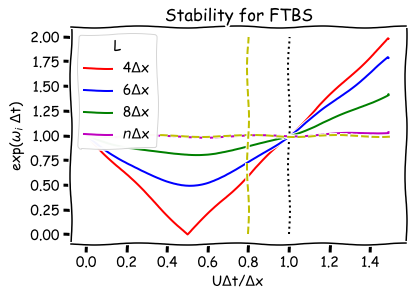

In [6]:
#############################################
#
# Calculating Stability Parameters for 
#   Plotting (Not for the Model)
#

UDTDX = np.arange(0.01, 1.5, 0.01)

DT    = UDTDX/U*dx

K2 = 2.0*np.pi/(2.0*dx)
K3 = 2.0*np.pi/(3.0*dx)
K5 = 2.0*np.pi/(5.0*dx)
Kx = 2.0*np.pi/(L)


#
#############################################    

#############################################
#
# Plotting Amplification
#

with plt.xkcd():
    plt.plot(UDTDX,     np.sqrt( 1+2*UDTDX * ( np.cos(K2*dx)-1 ) * (1-UDTDX)), "r",
             UDTDX,     np.sqrt( 1+2*UDTDX * ( np.cos(K3*dx)-1 ) * (1-UDTDX)), "b",
             UDTDX,     np.sqrt( 1+2*UDTDX * ( np.cos(K5*dx)-1 ) * (1-UDTDX)), "g",
             UDTDX,     np.sqrt( 1+2*UDTDX * ( np.cos(Kx*dx)-1 ) * (1-UDTDX)), "m",

             [0.0,1.5], [1.0,1.0],                                             "k:",
             [1.0,1.0], [0.0,2.0],                                             "k:",
             [0.0,1.5],     [amplif,amplif],                                  "y--",
             [udtdx,udtdx],     [0.0,2.0],                                    "y--")
    plt.legend(('4$\Delta$x', '6$\Delta$x', '8$\Delta$x','$n\Delta$x'),
           loc='upper left',
           title="L")
    plt.title('Stability for FTBS')
    plt.xlabel(r'U$\Delta$t/$\Delta$x') 
    plt.ylabel(r'exp($\omega$$_i$ $\Delta$t)'); 
    
#
#############################################    

... then for wave speed errors. (you're still at the yellow crosshair and magenta line)

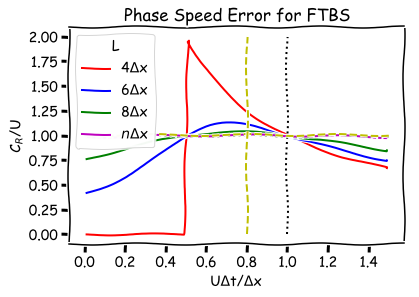

In [7]:
#############################################
#
# Plotting Speed Errors
#

with plt.xkcd():
    plt.plot(UDTDX, 1/K2/DT/U * np.arctan2(UDTDX*np.sin(K2*dx) ,  1+UDTDX*(np.cos(K2*dx)-1) ), "r",
             UDTDX, 1/K3/DT/U * np.arctan2(UDTDX*np.sin(K3*dx) ,  1+UDTDX*(np.cos(K3*dx)-1) ), "b",
             UDTDX, 1/K5/DT/U * np.arctan2(UDTDX*np.sin(K5*dx) ,  1+UDTDX*(np.cos(K5*dx)-1) ), "g",
             UDTDX, 1/Kx/DT/U * np.arctan2(UDTDX*np.sin(Kx*dx) ,  1+UDTDX*(np.cos(Kx*dx)-1) ), "m",

             [0.0,1.5], [1.0,1.0],                                             "k:",
             [1.0,1.0], [0.0,2.0],                                             "k:",
             [0.0,1.5],     [spderr,spderr],                                  "y--",
             [udtdx,udtdx],     [0.0,2.0],                                    "y--")

    plt.legend(('4$\Delta$x', '6$\Delta$x', '8$\Delta$x','$n\Delta$x'),
           loc='upper left',
           title="L")
    plt.title('Phase Speed Error for FTBS')
    plt.xlabel(r'U$\Delta$t/$\Delta$x') 
    plt.ylabel(r'C$_R$/U');
    
#
#############################################    

## Let's Model!

Now we're ready to try to model our system. We have two ways we can do this.  One is to just plot a series of single plots of our wave with one for our time step.  The other is to animate them.  Both use most of the same code.  

... But before we go....

### "Who is the mother-flipping flipper-mother who thought *this* was a good idea."

When migrating from older languagtes like Fortran, C or even more "modern" langaugtes like NCL (which is going Python with the rest of NCAR), you may be used to what is, aparently, called inclusive indexing... because for some reason there wouldn't be a need to give a such a thing specific adjective when you'd think that it wouldn't be so bloody obvious and intuitive to do it any other way.

But Oh No.........

Python along with a couple other supernew language do something different...

Let's first borrow from a commonly used language like MATLAB, IDL or NCL (let's assume that we start our indexing with 0 like Python does.

```
strawman := (/ 1, 2, 3, 4, 5 /)
```

Let's ask for the last two values...  Normally we woud intuit that it'd be ...


```
print( strawman(3:4)) 

(/ 4, 5 /)
```

Now let's do the same thing in Python

In [8]:
#
# let's make a no-nonsense array
#

strawman = np.array([ 1, 2, 3, 4, 5])
print('strawman[] =', strawman)

strawman[] = [1 2 3 4 5]


In [9]:
#
# and let's pull what we think should be the last two?
#

print('strawman[3:4] =', strawman[3:4])

strawman[3:4] = [4]


Whaaaa?

OK here is what is happening when "slicing," as it's called, an array Python does something that may be seen to be counterintuitve.  

* the first index that is requested list or array subset is *inclusive*
    * that measn that what you ask for is what you get.  You ask for the 0 index, or in this case index #4 when starting at zero, you ask for "3" get that one. 
    
    
But..

* the closing index that is requested from a list or array subset is *exclsuive* 
    * so when you ask for the subset ending at #5 from zero.. it gives you... #4 from zero.
    * so if you want number #5 from zero instead of typing "4", you type the next one... "5".

In [10]:
#
# so if you use the way we normally think about it...
#

print('strawman[3:4+1] =', strawman[3:4+1])

# or

print('strawman[3:5] =', strawman[3:5])

strawman[3:4+1] = [4 5]
strawman[3:5] = [4 5]


If you want to go from a array value 4 to the end of the array you *could* do this.  This is similar to NCL...  but as shown here if you look closer there is a lack of consistancy of you forget that the first value *requested* is "inclusive", the second *requested* is exclusive.

In [11]:
print('strawman[  3: ] =',  strawman[ 3:  ]) # second to last their way
print('strawman[  3  ] =',  strawman[   3 ]) # second to last alone
print('strawman[  4  ] =',  strawman[   4 ]) # last alone (first request is inclusive)
print('strawman[  -2 ] =',  strawman[  -2 ]) # second from last
print('strawman[  -1 ] =',  strawman[ -1  ]) # first from last first request is inclusive
print('strawman[-2:-1] =',  strawman[-2:-1]) # the last value is exclusive
print('strawman[-2:  ] =',  strawman[-2:  ]) # how they want you to pull the last 2.

strawman[  3: ] = [4 5]
strawman[  3  ] = 4
strawman[  4  ] = 5
strawman[  -2 ] = 4
strawman[  -1 ] = 5
strawman[-2:-1] = [4]
strawman[-2:  ] = [4 5]


To emulate what we often do to calculate gradients in bulk such as 

```
ns          = 5
delta_straw = strawman[1:nx-1] - strawman[0:nx-2]
```
you will want to do it *this* way:

In [12]:
#
# making a gradient without a loop
#

ns            = 5

print("gradient of strawman : ", (strawman[1:] - strawman[:-1]))

#
# where that -1 means one from the end.
#

gradient of strawman :  [1 1 1 1]


When you [JFGI](http://lmgtfy.com/?q=why+is+the+mother-flipping+python+indexing+inclusive+for+the+first+index+then+exclusive+for+the+second) what why this is the case you get an argument from "elegance."  

Whatever... but still. Flip these mother-flipping flipper-mothers... 

"elegance is skin deep... but intuitive functionality is to the bone"

So let's continue

## Finite Differencing Regime for FTBS

Let's remember the formation of our FTBS calculation

$\begin{align*} \\
\frac{\partial{h}}{\partial{t}} &= -u\frac{\partial{h}}{\partial{x}} \\ \\
\frac{h^{\tau + 1}_{j} - h^{\tau}_{j} }{\Delta t} &= -u \frac{h^{\tau}_{j} - h^{\tau}_{j-1} }{\Delta x} \\ \\
h^{\tau + 1}_{j} &=  h^{\tau}_{j} - \frac{u \Delta t}{\Delta x} \big( h^{\tau}_{j} - h^{\tau}_{j-1}  \big)
\end{align*}$ 

For our lateral boundary conditions (well, lateral is the only boundary conditions we have here since it's a 1-d model) will use a *periodic* boundary condition.  For this we calculate our horizontal gradient across at index zero (our make-belive prime meridian) by getting out $j-1$ index from the last value in the array.

### Stability Parameters
Let's start by looking at our stability parameters

In [13]:
#############################################
#
# printing the resulting values
#

print('  Domain Circumfrence =', (nx * dx/1000.), "km")
print('    Simulation Period =', (nt * dt/3600.), "hr")
print('           Space Step =',  dx/1000., "km")
print('            Time Step =',  dt, "sec")
print(' number of time steps =', nt, 'frames')
print('number of space steps =', nx, 'cells')

print(' ')
print('        CFL Criteria =', udtdx)
print(' Stability Criteria  =', amplif)
print('        Speed Error  =', spderr)
print(' ')
print('                   k =',     k, 'm-1')
print("               omega =",     w, 's-1')
print('                   L =',     L/1000., 'km' )
print('                L/dx =',  L/dx,    'space steps per grid cell')
print('           L/circumf =',  dx*nx/L, 'waves per system')


#
############################################# 

  Domain Circumfrence = 100.0 km
    Simulation Period = 3.0 hr
           Space Step = 1.0 km
            Time Step = 40.0 sec
 number of time steps = 270 frames
number of space steps = 100 cells
 
        CFL Criteria = 0.8
 Stability Criteria  = 0.9921381381715195
        Speed Error  = 1.0019828963905828
 
                   k = 0.0003141592653589793 m-1
               omega = 0.006283185307179586 s-1
                   L = 20.0 km
                L/dx = 20.0 space steps per grid cell
           L/circumf = 5.0 waves per system


### Plotting the results

There are two ways to plot the output as presented here.  The first is to create a series of basic plots.  In this case we are using the MATLAB since that is one of the more commonly-used plotting frameworks being used in Python.  

The plotting in this next section uses a simple loop to more forward in time with our FTBS finite-differencing regime for basic advection. 

This is pretty no-nonsense but doesn't have the spiffy look-n-feel of an animated time series of the wave changing over time.

In [14]:
#############################################
#
# Modeling the Wave for Individual Plots
#

if (make_individual_plots) :

    #
    # loop through time steps
    #

    for tau in range(0,nt) :

        t = tau*dt  # real-world time

        h_an    = np.cos(k*x   - w*t) # analytic solution
        h_an_hi = np.cos(k*xhi - w*t) # high-rez analytial solution

        if (tau == 0) :

            #
            # initialize time steps to the analytic solution
            #

            h_tp1 = h_an # t+1 next time step
            h_tp0 = h_an #  t  current time step

        else :

            #
            # calculate next time step
            #

            h_tp1[1:] = h_tp0[1:] - udtdx * ( h_tp0[1:] - h_tp0[:-1] ) 
            h_tp1[0]  = h_tp0[0]  - udtdx * ( h_tp0[0]  - h_tp0[-1]  ) # periodic BCs

        #
        # get current wave amplitude (since when waves are damped,
        # it will be harder to see.
        #

        amplitutude =  (0.5 * (np.max(h_tp1) - np.min(h_tp1)))

        #
        # plot current wave solution
        #
        #  red dots     : finite-difference solution
        #  cyan line    : analytic solution
        #  magenta line ; normalized finite-difference solution 

        plt.plot(x/1000,   h_tp1,               "or",
                 x/1000,   h_tp1 / amplitutude, "m",
                 xhi/1000, h_an_hi,             "c")
        plt.title('FTBS Simulation at τ = %i, t = %i s' %(tau, t) )
        plt.ylim( -1.2, 1.2 )
        plt.legend(('FTBS', 'FTBS(norm)', 'Analytic'),
                   loc='upper right')
        plt.xlabel('x (km)')
        plt.ylabel('h')

        #
        # make the next time step the current time step
        #

        h_tp0 = h_tp1

#
#############################################   

### Implementing Animation

If we wish to animate the process we will need to get fancy and a little counter intuitive.  And since we are already working in Python (and this tutorial is written for people relatively new to the Python environment) 

... what the heck

Rather than describe what is going on here beyond a view from 30,000 feet, meatier comments are going into the acutal code

But if you want a basic outline of what is happening

1. create any larger time-dependant data (which we have to do here since the finite difference method is dependant on any FTBS output that comes before the current time step.
2. create a function that will draw each "frame."  It should have one argument going into it (the frame index which for us is our time index, $\tau$.
3. call a function to create the animation.  Ours will be [matplotlib.animation.FuncAnimation()](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html).
4. Deliver the product. You can save it as an mpeg, or as a animated gif.  In our case we are embedding the anomation into the notebook (which is HTML markup).  The function we are using is [IPython.display.HTML](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.HTML) to send the animation as a _myAnimation_.to_html5_video object



Embedding Animation (you need to be patient here)


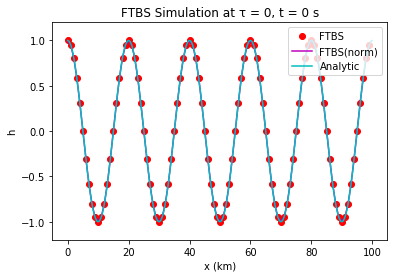

In [15]:
#############################################
#
# Modeling the Wave for Animated Plots
#

h_fd     = np.zeros((nt,nx))  # make a all-zero 2-d array
                              # Python is Row-Major like C or NCL
                              # the "fastest index" should be the 
                              # right-most array

tau      = 0         # drop a first time step 
t        = tau * dt  # for the initial conditions


h_fd[tau,] =  np.cos(k*x   - w*t) # put the analytic solution in for 
                                  # the initial conditions
    
#
# above, we plotted as we want through the loop.  
#
# here, we are going to create the entire modeled solution in advance
#

for tau in range(0,nt) : # remember that 0 is inclusive but the nt is exclusive

    t = tau*dt  # real-world time

    if (tau == 0) :

        #
        # initialize time steps to the analytic solution
        #

        h_fd[tau,] = np.cos(k*x   - w*t) # current time sheet

    else :

        #
        # calculate next time step
        #

        h_fd[tau,1:] = h_fd[tau-1,1:] - udtdx * ( h_fd[tau-1,1:] - h_fd[tau-1,:-1] )
        h_fd[tau,0]  = h_fd[tau-1,0]  - udtdx * ( h_fd[tau-1,0]  - h_fd[tau-1,-1]  )
        
#
# here is where things get a little strange.
#   plotting for animations is done through
#   a function matplotlib.animation.FuncAnimation()
#   there is an implicit loop in the function and the
#   index for the loop is passed through a section function
#   that generates the graph.
#
# we're calling this function below "update" and its input
#   input argument is "tau" (our time step)
# 
# the function 
#
#   1) calculates the analytic solution (since it's
#      not dependant on any data before hand)
#   
#   2) clears the plot for the "next" time step
#
#   3) plots the graph for that time step as you'd do
#      in the above case with the series of ordinary 
#      graphs.
#
#   4) "returns" to the larger FuncAnimation() function
#
    
def update(tau):
    t = dt * tau
    h_an_hi  = np.cos(k*xhi - w*t) # high-rez analytial solution
    amplitutude =  (0.5 * (np.max(h_fd[tau,:]) - np.min(h_fd[tau,:])))

    plt.gca().cla()  # clear the current graph (even though a sounds for axes it does everything)

    plt.plot(x/1000,   h_fd[tau,:],               "or",
             x/1000,   h_fd[tau,:] / amplitutude, "m",
             xhi/1000, h_an_hi,                   "c")
    plt.ylim( -1.2, 1.2 )
    plt.title('FTBS Simulation at τ = %i, t = %i s' %(tau, t) )
    plt.legend(('FTBS', 'FTBS(norm)', 'Analytic'),
               loc='upper right')
    plt.xlabel('x (km)')
    plt.ylabel('h')

#
# before we call the function we must generate the plot 
# device (if we were in NCL).  In this case it's a set of 
# subplots
#
# the "ax" is code for an axis-based graphic
#

fig, ax = plt.subplots()

#
# and here is where we create the animation
#

ani = animation.FuncAnimation(fig,       # the graphical "device"
                              update,    # the update "function"
                              frames=nt) # how many frames (for us tau)

#
# finally we can drop the animation into our Jupyter notebook.
#
# (this takes a while)
#

print("Embedding Animation (you need to be patient here)")


display.HTML(ani.to_html5_video())

ani.save(filename = './FTBS_Advection.gif', 
         writer   = 'imagemagick',
         fps      = 60)

#
#############################################   